# COVID screening lab simulation

This version of the simulation is based on the following process description, with the option to adjust the batch size of the hat stage, e.g. 93 or 372 tubes as on one process step).

<img src="figs/process_9.png">

## Requirements and module imports

Code in this simulation uses a standard Anaconda Python environment (https://www.anaconda.com/distribution/#download-section). Additionally this model uses SimPy3 (https://simpy.readthedocs.io/en/latest/). Install SimPy3 with `pip install 'simpy<4'`.

In [1]:
import simpy
import inspect
from sim_utils.replication import Replicator
from sim_utils.parameters import Scenario

## Set up scenarios

Parameters defined in scenarios will overwrite default values in the parameters python file.

In [2]:
# Set up a dictionary to hold scenarios
scenarios = {}

# Removing RNA prep (note use of dummy resources in process_resources)
scenarios['no_rna_prep'] = Scenario(
    
    samples_per_day = 30132,
    
    # List of delivery times (from start of day)
    delivery_times = [0],
    
    process_resources = {
                'sample_receipt': {
                    'process_type': 'manual',
                    'human_list': (['human_sample_receipt_1',
                                    'human_sample_receipt_2'],
                                   ['tracker_sample_receipt_fte'],
                                   ['tracker_all_jobs_fte'],
                                   ['tracker_sample_receipt_jobs']),
                    'machine_list': ([],)},

                'sample_prep_manual': {
                    'process_type': 'manual',
                    'human_list': (['human_sample_prep_1',
                                    'human_sample_prep_2'],
                                   ['human_pcr_1',
                                    'human_pcr_2',
                                    'human_sample_receipt_1',
                                    'human_sample_receipt_2'],
                                   ['tracker_all_jobs_fte'],
                                   ['tracker_sample_prep_jobs'],
                                   ['tracker_sample_prep_fte']),
                    'machine_list': ([],)},

                'sample_prep_auto': {
                    'process_type': 'auto',
                    'human_list': (['human_sample_prep_1',
                                    'human_sample_prep_2'],
                                   ['tracker_all_jobs_fte'],
                                   ['tracker_sample_prep_jobs'],
                                   ['tracker_sample_prep_fte']),
                    'machine_list': (['sample_prep_automation'],
                                     ['tracker_sample_prep_jobs'])},

                'sample_heat': {
                    'process_type': 'auto',
                    'human_list': (['human_sample_prep_1',
                                    'human_sample_prep_2'],
                                   ['tracker_all_jobs_fte'],
                                   ['tracker_heat_fte']),
                    'machine_list': (['sample_heat_incubator'],
                                     ['tracker_heat_jobs'])},

                'rna_extraction': {
                    'process_type': 'auto',
                    'human_list': (['dummy'],),
                    'machine_list': (['dummy'],)},

                'pcr_prep':{
                    'process_type': 'auto',
                    'human_list': (['human_pcr_1',
                                    'human_pcr_2'],
                                   ['tracker_all_jobs_fte'],
                                   ['tracker_pcr_prep_fte']),
                    'machine_list': (['pcr_plate_stamper'],
                                     ['tracker_pcr_prep_jobs'])},

                'pcr':{
                    'process_type': 'auto',
                    'human_list': (['human_pcr_1',
                                    'human_pcr_2'],
                                   ['tracker_all_jobs_fte'],
                                   ['tracker_pcr_fte']),
                    'machine_list': (['pcr_plate_reader'],
                                     ['tracker_pcr_jobs'])},
                },
    
    process_duration = {
             'batch_input': ([0,0,0],),
             'sample_receipt': ([33, 0, 0],),
             'sample_prep_manual': ([51, 0, 0],),
             'sample_prep_auto': ([25, 0, 0], [6, 0, 0], [6, 0, 0]),
             'sample_heat':  ([2, 0, 0], [20, 0, 0], [2, 0, 0]),
             'pcr_prep': ([45,0,0],[5,0,0],[4,0,0]),
             'pcr': ([5,0,0],[90,0,0],[5,0,0]),
             'rna_extraction': ([0, 0, 0], [0, 0, 0], [0, 0, 0]),
             'data_analysis': ([0,0,0],)
             },

    
    fte_resources = [
            'human_sample_receipt_1',
            'human_sample_receipt_2',
            'human_sample_prep_1',
            'human_sample_prep_2',
            'human_pcr_1',
            'human_pcr_2',
            ]
)

## Run model

                                                                               
Output results
--------------
                                            min       mean     median  \
                                         Result     Result     Result   
result_type               name                                          
demand_met                no_rna_prep      1.00      1.000      1.000   
input                     no_rna_prep  30132.00  30132.000  30132.000   
max_process_time_hours    no_rna_prep     15.87     16.252     16.215   
median_process_time_hours no_rna_prep     15.87     16.252     16.215   
output                    no_rna_prep  30132.00  30132.000  30132.000   

                                            max  
                                         Result  
result_type               name                   
demand_met                no_rna_prep      1.00  
input                     no_rna_prep  30132.00  
max_process_time_hours    no_rna_prep     16.87  
media

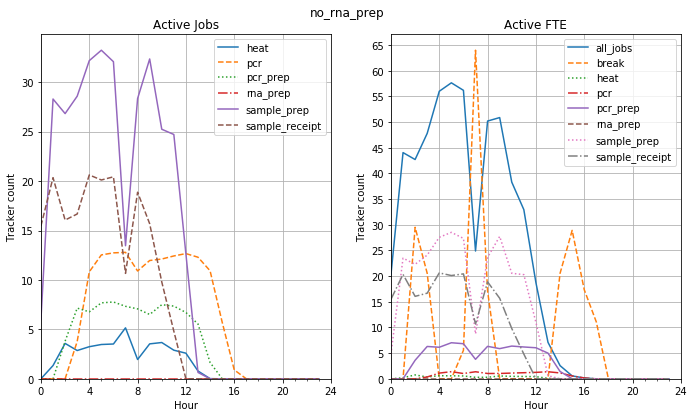

In [3]:
replications = 30
replications = Replicator(scenarios, replications)
replications.run_scenarios()

## Show model default parameters

Run the code below to model defaults these are over-ridden by scenarios).

In [4]:
print(inspect.getsource(Scenario.__init__))

    def __init__(self, *initial_data, **kwargs):
        
        # Set default values
        # 16/4/2020 Adjust paramters so that day starts with FTE arrival


        # Work arrival
        self.samples_per_day = 30132
        # List of sample arrival times (from start of day)
        self.delivery_times = [0]
        self.basic_batch_size = 93

        # Day and run parameters
        # 16/4/2020 Model is designed to run primarily in single days
        self.day_duration = 1440
        self.run_days = 1
        self.warm_up_days = 0
        
        # Breaks for people (high priority job, but does not interrupt work)
        # Times from start of FTE day (6am)
        self.tea_break_times = [2*60, 16*60]
        self.meal_break_times = [6.5*60, 14*60]
        # Spread start of break for people randomly after set start times
        self.break_start_spread = 60
                
        # break duration is a uniform distribution between min and max
        self.tea_break_duration = [